In [18]:
import math

import hoomd

In [19]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import os
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    central_color = fresnel.color.linear([252 / 255, 41 / 255, 0 / 255])
    constituent_color = fresnel.color.linear([93 / 255, 210 / 255, 252 / 255])

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=[0, 0, 0], roughness=0.5, primitive_color_mix=1.0
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.color[snapshot.particles.typeid[:] == 0] = central_color
    geometry.radius[snapshot.particles.typeid[:] == 0] = 0.3
    geometry.color[snapshot.particles.typeid[:] == 1] = constituent_color
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

In [20]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/dimer_lattice.gsd")

hoomd.md.constrain.Rigid is responsible for applying the rigid body constraints to the particles in the simulation.

Create the rigid constraint:

In [21]:
rigid = hoomd.md.constrain.Rigid()

The body property of Rigid is not saved to the GSD file. You need to define the parameters again in the new simulation:

In [22]:
rigid.body["dimer"] = {
    "constituent_types": ["A", "A"],
    "positions": [[-1.2, 0, 0], [1.2, 0, 0]],
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
}

Create an Integrator with the option integrate_rotational_dof=True

In [23]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
simulation.operations.integrator = integrator

The default value of integrate_rotational_dof is False, When False, the integrator will ignore all torques on particles and integrate only the translational degrees of freedom. When True, the integrator will integrate both the translational and rotational degrees of freedom.

Assign the rigid constraint to the integrator's rigid attribute to apply the constraints during the simulation.

In [24]:
integrator.rigid = rigid

The translational and rotational degrees of freedom are given to the central particles of the rigid bodies. Select only the rigid centers and free particles for the integration method:

In [25]:
kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.ConstantVolume(
    filter=rigid_centers_and_free, thermostat=hoomd.md.methods.thermostats.Bussi(kT=kT)
)
integrator.methods.append(nvt)

Create a neighbor list with body exclusions so that the pair potential does not compute intra-body interactions:

In [26]:
cell = hoomd.md.nlist.Cell(buffer=0, exclusions=["body"])

Without body exclusions, the simulation may be numerically unstable due to round-off errors when subtracting large numbers. In either case, the intra-body forces contribute 0 to the net force and 0 to the net torque, so there is no need to compute them.

Apply the Lennard-Jones potential between A-A particle pairs.

In [27]:
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5

The central particles (type dimer) are also present in the system. Make the dimer particles non-interacting with a 0 r_cut:

In [28]:
lj.params[("dimer", ["dimer", "A"])] = dict(epsilon=0, sigma=0)
lj.r_cut[("dimer", ["dimer", "A"])] = 0

In [29]:
integrator.forces.append(lj)

Compressing the System
We have initialized the system state, added the integrator, set the rigid constraint, and defined the pairwise particle interactions. Before we run the simulation, we need to set initial velocities and angular momenta of the rigid body central particles and free particles:

In [30]:
simulation.state.thermalize_particle_momenta(filter=rigid_centers_and_free, kT=kT)
simulation.run(0)

thermalize_particle_momenta assigns Gaussian distributed momenta to each translational and rotational degree of freedom for each particle given in the filter. In this case, it will assign momenta about the y and z axes, but not x because Ixx = 0

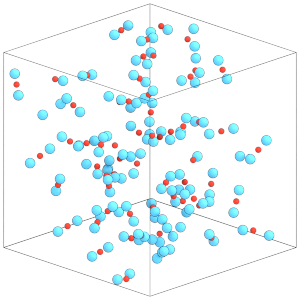

In [31]:
simulation.run(1000)
render(simulation.state.get_snapshot())

This simulation box is dilute. Compress the box to a higher density state before continuing:

In [32]:
initial_box = simulation.state.box
final_volume = initial_box.volume / 16
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=20_000,
)
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp,
)
simulation.operations.updaters.append(box_resize)

In [33]:
simulation.run(60000)

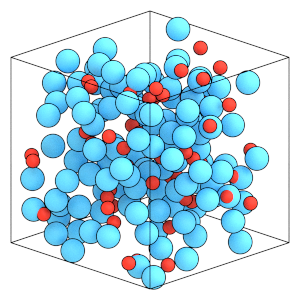

In [34]:
render(simulation.state.get_snapshot())

Add the ThermodynamicQuantities compute to the simulation:

In [35]:
thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_quantities)

ThermodynamicQuantities computes translational and rotational kinetic energy separately:

In [36]:
thermodynamic_quantities.translational_kinetic_energy

162.86570899591163

In [37]:
thermodynamic_quantities.rotational_kinetic_energy

92.26115961398625

These values are consistent (within expected thermodynamic fluctuations) with the equipartition theorem:

In [39]:
translational_degrees_of_freedom = (
    thermodynamic_quantities.translational_degrees_of_freedom
)
print("Translational degrees of freedom:", translational_degrees_of_freedom)
print(
    "1/2 kT * translational degrees of freedom:",
    1 / 2 * kT * translational_degrees_of_freedom,
)

Translational degrees of freedom: 189.0
1/2 kT * translational degrees of freedom: 141.75


In [40]:
rotational_degrees_of_freedom = thermodynamic_quantities.rotational_degrees_of_freedom
print("Rotataional degrees of freedom:", rotational_degrees_of_freedom)
print(
    "1/2 kT * rotational degrees of freedom:",
    1 / 2 * kT * rotational_degrees_of_freedom,
)

Rotataional degrees of freedom: 128.0
1/2 kT * rotational degrees of freedom: 96.0
